In [2]:
# libraries
import json
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, GPT2Model, BertTokenizer, GPT2Tokenizer
from tqdm import tqdm
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

from torch.nn import TransformerEncoder, TransformerEncoderLayer,TransformerDecoderLayer,TransformerDecoder
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class EmotionTriggerDataset(Dataset):
    def __init__(self, data_file, max_length=512):
        with open(data_file, 'r') as f:
            data = json.load(f)

        self.data = data
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.bert_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

        self.max_length = max_length
        self.label_mapping = {'disgust': 0,
                               'anger': 1,
                               'sadness': 2,
                               'surprise': 3,
                               'neutral': 4,
                               'joy': 5,
                               'fear': 6,
                              '<pad>': 8}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        last_idx = len(self.data[idx]['speakers'])-1
        speaker = self.data[idx]['speakers']
        utterances = self.data[idx]['utterances']
        emotions = self.data[idx]['emotions']
        final_utterance = [s + '  ' + u + '  ' + e for s, u, e in zip(speaker, utterances, emotions)] # X
        final_utterance = final_utterance + [self.bert_tokenizer.pad_token] * (24 - len(final_utterance))

        triggers = self.data[idx]['triggers'] # y
        temp = []
        for i in triggers:
            if i == None:
                temp.append(0)
            else:
                temp.append(i)
        temp += [2] * (24 - len(temp))   # 2 is pad token

        bert_inputs = self.bert_tokenizer(final_utterance, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='np')
        bert_input_ids = torch.tensor(bert_inputs['input_ids'],dtype=torch.float32)

        trigger_labels = torch.tensor(temp, dtype=torch.float32)

        return bert_input_ids, bert_input_ids[last_idx].unsqueeze(0), trigger_labels

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: nn) -> nn:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, d_model: int =512, nhead: int=64, d_hid: int=200,nlayers: int=8, dropout: float = 0.2):
        super(Encoder, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)


    def forward(self, x):
        x= x.permute(1,0,2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, d_model: int =512, nhead: int=64, d_hid: int=200,nlayers: int=8, dropout: float = 0.2):
        super(Decoder, self).__init__()
        decoder_layers = TransformerDecoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

    def forward(self,last,memory):
        x= last.permute(1,0,2)
        x = self.pos_encoder(x)
        x = self.transformer_decoder(x,memory)
        return x

import torch
import torch.nn as nn

class EmotionClassifier(nn.Module):
    def __init__(self, input_size=512, hidden_size=64, output_size=24, num_layers=1, num_classes=3):
        super(EmotionClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * num_classes)  # Change output size
        self.activation = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out)  # out: tensor of shape (batch_size, seq_length, output_size * num_classes)

        # Reshape the output to (batch_size, seq_length, output_size, num_classes)
        out = out.view(out.size(0), out.size(1), 24, -1)

        # Apply sigmoid activation function to get values between 0 and 1
        out = self.activation(out)

        return out


In [6]:
class EmotionTriggerModel(nn.Module):
    def __init__(self, d_model=512, nhead=128, d_hid=400, encoder_layers=32, decoder_layers=32, hidden_size=64, output_size=24):
        super(EmotionTriggerModel, self).__init__()

        self.encoder = Encoder(d_model=d_model, nhead=nhead, d_hid=d_hid, nlayers=encoder_layers)
        self.decoder = Decoder(d_model=d_model, nhead=nhead, d_hid=d_hid, nlayers=decoder_layers)
        self.emotion_classifier = EmotionClassifier(input_size=d_model, hidden_size=hidden_size, output_size=output_size)

    def forward(self, input_ids, last):
        encoder_output = self.encoder(input_ids)
        # last_output = encoder_output[-1].unsqueeze(0)  # Taking the last output from encoder
        decoder_output = self.decoder(last, encoder_output)
        emotion_output = self.emotion_classifier(decoder_output)
        # print("emotion_output_class", emotion_output.shape)
        x = emotion_output.squeeze(0)
        return x.squeeze(0)

In [ ]:
# dataloader
data_file = '/Data/train_file.json'
dataset = EmotionTriggerDataset(data_file)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [7]:
# Load val data
val_file = "/Data/val_file.json"
with open(val_file, 'r') as f:
    val_data = json.load(f)

# Create val dataset and dataloader (assuming you have a similar dataset and dataloader for the val data)
val_dataset = EmotionTriggerDataset(val_file, max_length=512)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model = EmotionTriggerModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Store training and val losses and accuracies
train_losses = []
val_losses = []
f1_scores = []

train_accuracies = []
val_accuracies = []


# Training Loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Training
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", colour='#FFBEB2', ncols=100):
        inputs, last, labels = batch
        inputs = inputs.to(device)
        last = last.to(device)
        labels = labels.to(device)
        labels_one_hot = F.one_hot(labels.long(), num_classes=3).float()

        optimizer.zero_grad()
        outputs = model(inputs, last)
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        predicted_labels = (outputs >= 0.5).float()
        predicted_labels_arg = torch.argmax(predicted_labels, dim=2)
        predicted_labels_flatten = predicted_labels_arg.flatten()
        labels_flatten = labels.flatten()

        tr_ac = accuracy_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'))
        train_accuracies.append(tr_ac)

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    train_acc = np.mean(np.array(train_accuracies))


    print(f"Epoch {epoch+1}/{num_epochs} (Train), Loss: {average_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # val
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (val)", colour='#41B7C4', ncols=100):
        inputs, last, labels = batch
        inputs = inputs.to(device)
        last = last.to(device)
        labels = labels.to(device)
        labels_one_hot = F.one_hot(labels.long(), num_classes=3).float()

        outputs = model(inputs, last)
        loss = criterion(outputs, labels_one_hot)
        total_loss += loss.item()

        predicted_labels = (outputs >= 0.5).float()
        predicted_labels_arg = torch.argmax(predicted_labels, dim=2)
        predicted_labels_flatten = predicted_labels_arg.flatten()
        labels_flatten = labels.flatten()

        f1 = f1_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'), average='macro')
        f1_scores.append(f1)

        val_acc =  accuracy_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'))
        val_accuracies.append(val_acc)


    average_loss = total_loss / len(val_loader)
    val_losses.append(average_loss)

    val_accuracy = np.mean(np.array(val_accuracies))
    avg_f1_score = np.mean(np.array(f1_scores))

    print(f"Epoch {epoch+1}/{num_epochs} (val), Loss: {average_loss:.4f}, Accuracy: {val_accuracy:.2f}%, f1-score: {avg_f1_score}")

    model.train()

print("Training complete!")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:33<00:00,  1.38it/s]


Epoch 1/10 (Train), Loss: 23.9068, Accuracy: 0.74%


Epoch 1/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.60it/s]


Epoch 1/10 (val), Loss: 23.8063, Accuracy: 0.72%, f1-score: 0.5462429650998872


Epoch 2/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:19<00:00,  1.51it/s]


Epoch 2/10 (Train), Loss: 23.7549, Accuracy: 0.73%


Epoch 2/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.30it/s]


Epoch 2/10 (val), Loss: 23.7957, Accuracy: 0.72%, f1-score: 0.5462429650998872


Epoch 3/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:13<00:00,  1.58it/s]


Epoch 3/10 (Train), Loss: 23.7491, Accuracy: 0.74%


Epoch 3/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.60it/s]


Epoch 3/10 (val), Loss: 23.7925, Accuracy: 0.72%, f1-score: 0.5462429650998871


Epoch 4/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:13<00:00,  1.58it/s]


Epoch 4/10 (Train), Loss: 23.7470, Accuracy: 0.73%


Epoch 4/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.60it/s]


Epoch 4/10 (val), Loss: 23.7914, Accuracy: 0.72%, f1-score: 0.5462429650998872


Epoch 5/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:13<00:00,  1.58it/s]


Epoch 5/10 (Train), Loss: 23.7467, Accuracy: 0.74%


Epoch 5/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.29it/s]


Epoch 5/10 (val), Loss: 23.7916, Accuracy: 0.72%, f1-score: 0.5462429650998872


Epoch 6/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:13<00:00,  1.59it/s]


Epoch 6/10 (Train), Loss: 23.7458, Accuracy: 0.73%


Epoch 6/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.27it/s]


Epoch 6/10 (val), Loss: 23.7903, Accuracy: 0.72%, f1-score: 0.5462429650998871


Epoch 7/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:13<00:00,  1.58it/s]


Epoch 7/10 (Train), Loss: 23.7452, Accuracy: 0.73%


Epoch 7/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.71it/s]


Epoch 7/10 (val), Loss: 23.7902, Accuracy: 0.73%, f1-score: 0.5470776324289308


Epoch 8/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:13<00:00,  1.58it/s]


Epoch 8/10 (Train), Loss: 23.7447, Accuracy: 0.73%


Epoch 8/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.67it/s]


Epoch 8/10 (val), Loss: 23.7899, Accuracy: 0.73%, f1-score: 0.5477036329257137


Epoch 9/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:21<00:00,  1.49it/s]


Epoch 9/10 (Train), Loss: 23.7441, Accuracy: 0.73%


Epoch 9/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.78it/s]


Epoch 9/10 (val), Loss: 23.7905, Accuracy: 0.73%, f1-score: 0.5475413365006218


Epoch 10/10 (Train): 100%|████████████████████████████████████████| 211/211 [02:13<00:00,  1.58it/s]


Epoch 10/10 (Train), Loss: 23.7449, Accuracy: 0.73%


Epoch 10/10 (val): 100%|████████████████████████████████████████████| 27/27 [00:07<00:00,  3.49it/s]

Epoch 10/10 (val), Loss: 23.7895, Accuracy: 0.73%, f1-score: 0.5474114993605483
Training complete!


In [ ]:
# model_save_path = "/content/drive/MyDrive/NLP-Assign4/emotion_trigger_model.pth"
model_save_path = "/Model3.pth"
torch.save(model.state_dict(), model_save_path)

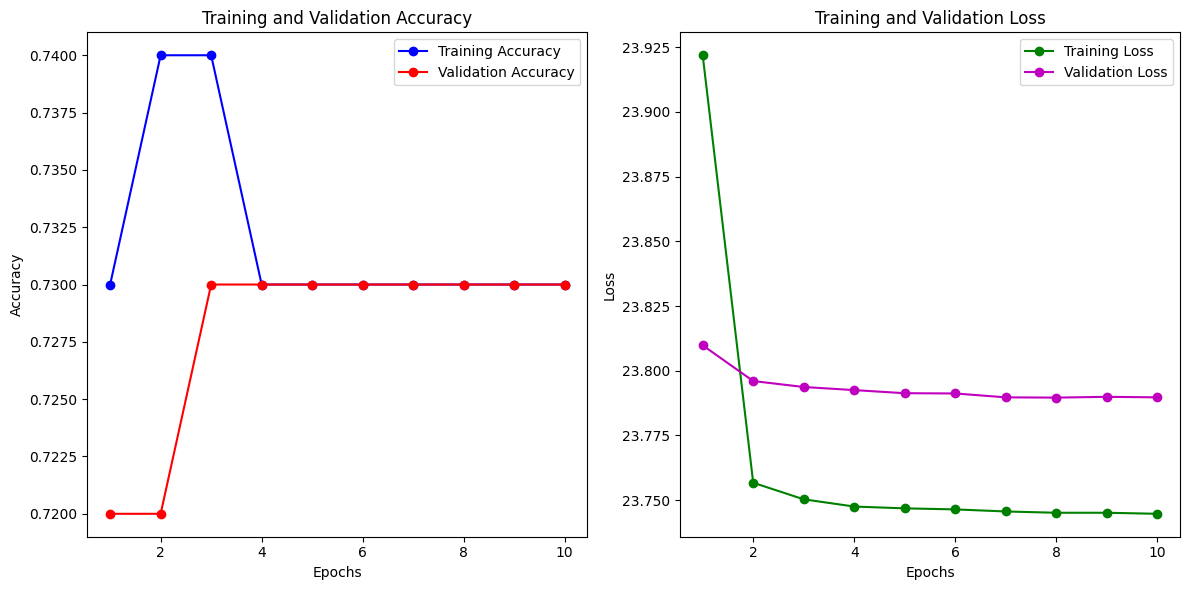

In [ ]:
epochs = list(range(1, 11))  # Number of epochs
plt.figure(figsize=(12, 6))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, marker='o', color='b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, marker='o', color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy_plot.png')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, marker='o', color='g', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', color='m', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss_plot.png')
plt.tight_layout()
plt.show()


In [7]:
# test data dataloader
test_file = "/Data/val_file.json"
dataset = EmotionTriggerDataset(test_file)
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = '/Model3.pth'
model = EmotionTriggerModel()
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

model.to(device)
model.eval()
f1_scores = []
acc = []
predicted = []
labels_see = []

for batch in tqdm(test_loader, desc="Evaluating on Test Data"):
    inputs, last, labels = batch
    inputs = inputs.to(device)
    last = last.to(device)
    labels = labels.to(device)
    labels_one_hot = F.one_hot(labels.long(), num_classes=3).float()

    with torch.no_grad():
        outputs = model(inputs, last)

    predicted_labels = (outputs >= 0.5).float()
    predicted_labels_arg = torch.argmax(predicted_labels, dim=2)
    predicted_labels_flatten = predicted_labels_arg.flatten()
    try:
      predicted.append((predicted_labels_arg[0].clone(),last_idx[0].clone()))
      predicted.append((predicted_labels_arg[1].clone(),last_idx[1].clone()))
      predicted.append((predicted_labels_arg[2].clone(),last_idx[2].clone()))
      predicted.append((predicted_labels_arg[3].clone(),last_idx[3].clone()))
      predicted.append((predicted_labels_arg[4].clone(),last_idx[4].clone()))
    except Exception as e:
      print(e)
    labels_flatten = labels.flatten()
    labels_see.append(labels_flatten)

    test_ac = accuracy_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'))
    f1 = f1_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'), average = 'macro')
    acc.append(test_ac)
    f1_scores.append(f1)

test_accuracy = np.mean(np.array(acc))
f1_score_test = np.mean(np.array(f1_scores))
print("Test accuracy: ", test_accuracy)
print(f"Test F1 Score: {f1_score_test:.4f}")


In [ ]:
pred = []
for i,j in predicted:
  temp = []
  for z in i[:j.item()+1].cpu().numpy():

    temp.append(z)
  pred.append(temp)